In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## XGBoost

In [8]:
import pandas as pd
import xgboost as xgb
import optuna
import joblib
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

print("Import libraries complete.")

# ===================================================================
# โหลดและเตรียมข้อมูล (Data Loading and Preparation)
# ===================================================================
try:
    # ลบย่อหน้าที่ผิดพลาด (Indentation) ออก
    filename = '/content/drive/MyDrive/Colab Notebooks/Data of hfmd.csv'
    hfmd = pd.read_csv(filename)
    df = hfmd.copy()

    # สร้างคอลัมน์เป้าหมาย (Target Column)
    df['risk_binary'] = df['risk_4'].apply(lambda x: 1 if x == 'yes' else 0)

    # เลือก Features และคอลัมน์ที่ต้องการ
    selected_features = [
        "mean_soil", "mean_tmax", "mean_tmin", "mean_vap",
        "mean_ws", "sum_ppt", "sum_soil", "sum_vap"
    ]
    reference_columns = ['year', 'month', 'ID_1']
    columns_to_include = selected_features + reference_columns + ['risk_binary']

    # กรองข้อมูลตามช่วงปีที่ต้องการ
    df_filtered = df[(df['year'] >= 2011) & (df['year'] <= 2018)][columns_to_include]

    # กำหนด X (Features) และ y (Target)
    X = df_filtered[selected_features]
    y = df_filtered['risk_binary']

    print(f"Data preparation complete.")
    print(f"ขนาดของข้อมูลทั้งหมดที่ใช้: X={X.shape}, y={y.shape}")
    print("-" * 30)

except FileNotFoundError:
    print(f"Error: ไม่พบไฟล์ที่ '{filename}'")
    print("กรุณาตรวจสอบ Path ของไฟล์และอัปโหลดไฟล์ให้ถูกต้องก่อนรันโค้ดส่วนถัดไป")
    # หยุดการทำงานถ้าหาไฟล์ไม่เจอ
    X, y = (None, None)

# ===================================================================
# สร้าง Objective Function และ Callback
# ===================================================================
# ตรวจสอบก่อนว่าข้อมูลพร้อมหรือไม่
if X is not None and y is not None:
    def objective(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'n_estimators': trial.suggest_int('n_estimators', 200, 2000, step=100),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
            'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
            'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
            'use_label_encoder': False,
            'random_state': 42
        }

        model = xgb.XGBClassifier(**params)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # เปลี่ยน scoring เป็น 'roc_auc'
        scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)

        return scores.mean()

    # --- สร้าง Callback function ---
    def print_best_auc_callback(study, trial):
        """
        ฟังก์ชันนี้จะถูกเรียกหลังจบแต่ละ trial เพื่อพิมพ์ค่า AUC ที่ดีที่สุดที่เจอ
        """
        print(f"Trial {trial.number} finished. Best AUC so far: {study.best_value:.5f}")

    # ===================================================================
    # เริ่มกระบวนการค้นหาด้วย Optuna (เพิ่ม Callback)
    # ===================================================================
    print("Starting Optuna optimization process...")
    study = optuna.create_study(direction='maximize')

    # เพิ่ม callbacks=[print_best_auc_callback]
    study.optimize(objective, n_trials=50, callbacks=[print_best_auc_callback])

    print("Optuna optimization finished.")

    # ===================================================================
    # แสดงผลลัพธ์, เทรนโมเดลสุดท้าย, และแสดงผล Metrics
    # ===================================================================
    print("\n" + "="*50)
    print("กระบวนการค้นหาเสร็จสิ้น!")
    trial = study.best_trial

    # เปลี่ยนการแสดงผลเป็น AUC
    print(f"  > Best CV AUC: {trial.value:.5f}")
    print(f"  > Best Parameters:")
    for key, value in trial.params.items():
        print(f"    - {key}: {value}")

    # นำพารามิเตอร์ที่ดีที่สุดมาสร้างและเทรนโมเดลสุดท้ายกับข้อมูลทั้งหมด
    print("\nTraining final model with the best parameters...")
    best_params = trial.params

    final_model = xgb.XGBClassifier(**best_params)
    final_model.fit(X, y)
    print("โมเดลสุดท้ายเทรนเสร็จเรียบร้อย!")

    print("\n" + "="*50)
    print("Calculating All Train Metrics (Performance on seen data)...")

    # ทำนายความน่าจะเป็น (สำหรับ AUC)
    y_train_pred_proba = final_model.predict_proba(X)[:, 1]

    # ทำนายค่า 0/1 (สำหรับ Accuracy, Precision, Recall, F1)
    y_train_pred_binary = final_model.predict(X)

    # คำนวณ Metrics
    train_auc = roc_auc_score(y, y_train_pred_proba)
    train_accuracy = accuracy_score(y, y_train_pred_binary)
    train_precision = precision_score(y, y_train_pred_binary)
    train_recall = recall_score(y, y_train_pred_binary)
    train_f1 = f1_score(y, y_train_pred_binary)

    # แสดงผล
    print(f"  > Train Accuracy : {train_accuracy:.5f}")
    print(f"  > Train Precision: {train_precision:.5f}")
    print(f"  > Train Recall   : {train_recall:.5f}")
    print(f"  > Train F1-Score : {train_f1:.5f}")
    print(f"  > Train AUC      : {train_auc:.5f}")

else:
    print("Data not loaded. Cannot train the model.")

[I 2025-11-05 14:09:56,826] A new study created in memory with name: no-name-6507481c-6c76-41a6-8ae8-4d5c28c010ef


Import libraries complete.
Data preparation complete.
ขนาดของข้อมูลทั้งหมดที่ใช้: X=(7390, 8), y=(7390,)
------------------------------
Starting Optuna optimization process...


[I 2025-11-05 14:10:06,297] Trial 0 finished with value: 0.7395819037071621 and parameters: {'n_estimators': 1800, 'learning_rate': 0.2582788602581937, 'max_depth': 3, 'subsample': 0.880144033287515, 'colsample_bytree': 0.5909978897525385, 'gamma': 0.057534260171360485, 'lambda': 5.811248773655179e-07, 'alpha': 1.3715978665926838e-07}. Best is trial 0 with value: 0.7395819037071621.


Trial 0 finished. Best AUC so far: 0.73958


[I 2025-11-05 14:10:22,121] Trial 1 finished with value: 0.7760919249114566 and parameters: {'n_estimators': 1000, 'learning_rate': 0.015126436738173042, 'max_depth': 8, 'subsample': 0.8028045351632114, 'colsample_bytree': 0.6463556697794892, 'gamma': 1.130578055797452e-08, 'lambda': 6.187017379841625e-06, 'alpha': 0.0810089051214433}. Best is trial 1 with value: 0.7760919249114566.


Trial 1 finished. Best AUC so far: 0.77609


[I 2025-11-05 14:11:16,420] Trial 2 finished with value: 0.7811559332544901 and parameters: {'n_estimators': 1700, 'learning_rate': 0.005346264409740183, 'max_depth': 10, 'subsample': 0.7308306943807832, 'colsample_bytree': 0.8990583196998473, 'gamma': 1.6843722305791948e-05, 'lambda': 0.8969820800002313, 'alpha': 4.801388355405785e-06}. Best is trial 2 with value: 0.7811559332544901.


Trial 2 finished. Best AUC so far: 0.78116


[I 2025-11-05 14:11:25,924] Trial 3 finished with value: 0.7583822615485067 and parameters: {'n_estimators': 800, 'learning_rate': 0.0022257596681319056, 'max_depth': 6, 'subsample': 0.8531248771827866, 'colsample_bytree': 0.6489498401654391, 'gamma': 9.851826514289234e-05, 'lambda': 2.3468271592897724e-08, 'alpha': 0.00017212162572568024}. Best is trial 2 with value: 0.7811559332544901.


Trial 3 finished. Best AUC so far: 0.78116


[I 2025-11-05 14:11:56,145] Trial 4 finished with value: 0.7723264319096345 and parameters: {'n_estimators': 800, 'learning_rate': 0.0023738913321139036, 'max_depth': 9, 'subsample': 0.9844312957225618, 'colsample_bytree': 0.9191545404548476, 'gamma': 1.0158850629217218e-08, 'lambda': 0.21322299521233662, 'alpha': 0.001942233584000128}. Best is trial 2 with value: 0.7811559332544901.


Trial 4 finished. Best AUC so far: 0.78116


[I 2025-11-05 14:12:02,544] Trial 5 finished with value: 0.7466567631323245 and parameters: {'n_estimators': 800, 'learning_rate': 0.0011293122468340432, 'max_depth': 6, 'subsample': 0.7541619247377986, 'colsample_bytree': 0.6085919297215994, 'gamma': 0.03990570307122301, 'lambda': 0.02160668249171348, 'alpha': 0.3066690136989644}. Best is trial 2 with value: 0.7811559332544901.


Trial 5 finished. Best AUC so far: 0.78116


[I 2025-11-05 14:12:19,179] Trial 6 finished with value: 0.7588258267518739 and parameters: {'n_estimators': 1400, 'learning_rate': 0.05362899006059199, 'max_depth': 10, 'subsample': 0.9892741536736924, 'colsample_bytree': 0.5289638990309131, 'gamma': 2.2354776592778044e-08, 'lambda': 1.5198117427063775e-06, 'alpha': 0.0002846539781063408}. Best is trial 2 with value: 0.7811559332544901.


Trial 6 finished. Best AUC so far: 0.78116


[I 2025-11-05 14:12:28,636] Trial 7 finished with value: 0.7444610998220555 and parameters: {'n_estimators': 1800, 'learning_rate': 0.001914139401034132, 'max_depth': 4, 'subsample': 0.9632756876584354, 'colsample_bytree': 0.6543441566196906, 'gamma': 0.000890800643937214, 'lambda': 1.3881912009132696e-06, 'alpha': 0.06979543792042595}. Best is trial 2 with value: 0.7811559332544901.


Trial 7 finished. Best AUC so far: 0.78116


[I 2025-11-05 14:13:40,692] Trial 8 finished with value: 0.7806968057685827 and parameters: {'n_estimators': 1700, 'learning_rate': 0.0017679958659012913, 'max_depth': 10, 'subsample': 0.8342947990277476, 'colsample_bytree': 0.8941717103077579, 'gamma': 1.8876167021401968e-08, 'lambda': 0.0009205791913589075, 'alpha': 0.2678028348704359}. Best is trial 2 with value: 0.7811559332544901.


Trial 8 finished. Best AUC so far: 0.78116


[I 2025-11-05 14:13:42,194] Trial 9 finished with value: 0.7386276621618251 and parameters: {'n_estimators': 200, 'learning_rate': 0.00208238165278849, 'max_depth': 5, 'subsample': 0.5213094614598721, 'colsample_bytree': 0.8066653484478203, 'gamma': 2.382956961756222e-06, 'lambda': 1.7098857485530903e-08, 'alpha': 0.004858284517688253}. Best is trial 2 with value: 0.7811559332544901.


Trial 9 finished. Best AUC so far: 0.78116


[I 2025-11-05 14:14:06,681] Trial 10 finished with value: 0.7795801110086514 and parameters: {'n_estimators': 1300, 'learning_rate': 0.010923365121610998, 'max_depth': 8, 'subsample': 0.6029013064310411, 'colsample_bytree': 0.9935764948121806, 'gamma': 4.038492101229311e-06, 'lambda': 0.5105948487171287, 'alpha': 5.118221942964458e-07}. Best is trial 2 with value: 0.7811559332544901.


Trial 10 finished. Best AUC so far: 0.78116


[I 2025-11-05 14:14:56,186] Trial 11 finished with value: 0.7766653096418102 and parameters: {'n_estimators': 2000, 'learning_rate': 0.007435930753535554, 'max_depth': 10, 'subsample': 0.6566628428978187, 'colsample_bytree': 0.8321971521768027, 'gamma': 7.908148827478021e-07, 'lambda': 0.0009794413621237825, 'alpha': 3.999834997288471e-06}. Best is trial 2 with value: 0.7811559332544901.


Trial 11 finished. Best AUC so far: 0.78116


[I 2025-11-05 14:15:26,579] Trial 12 finished with value: 0.7821629928708271 and parameters: {'n_estimators': 1500, 'learning_rate': 0.005130471421520745, 'max_depth': 8, 'subsample': 0.701577754227809, 'colsample_bytree': 0.9044462469733496, 'gamma': 0.00017389423939141564, 'lambda': 0.001145792413477981, 'alpha': 1.1921986019834964e-08}. Best is trial 12 with value: 0.7821629928708271.


Trial 12 finished. Best AUC so far: 0.78216


[I 2025-11-05 14:15:55,905] Trial 13 finished with value: 0.78141262465862 and parameters: {'n_estimators': 1500, 'learning_rate': 0.006128724445937008, 'max_depth': 8, 'subsample': 0.6892592307924957, 'colsample_bytree': 0.9996865201798516, 'gamma': 0.00041453944893212065, 'lambda': 0.02745853395417023, 'alpha': 2.1739101623922655e-08}. Best is trial 12 with value: 0.7821629928708271.


Trial 13 finished. Best AUC so far: 0.78216


[I 2025-11-05 14:16:16,844] Trial 14 finished with value: 0.7687321699608421 and parameters: {'n_estimators': 1400, 'learning_rate': 0.03284101094206587, 'max_depth': 8, 'subsample': 0.6796799598021284, 'colsample_bytree': 0.9951312103561197, 'gamma': 0.002632937206632459, 'lambda': 0.008114965094096227, 'alpha': 1.7706668666638075e-08}. Best is trial 12 with value: 0.7821629928708271.


Trial 14 finished. Best AUC so far: 0.78216


[I 2025-11-05 14:16:31,394] Trial 15 finished with value: 0.7760741137236001 and parameters: {'n_estimators': 1200, 'learning_rate': 0.005344903985836486, 'max_depth': 7, 'subsample': 0.5740699898541821, 'colsample_bytree': 0.741751237338214, 'gamma': 0.8866379314958166, 'lambda': 5.0890515391434726e-05, 'alpha': 1.9967518594806083e-08}. Best is trial 12 with value: 0.7821629928708271.


Trial 15 finished. Best AUC so far: 0.78216


[I 2025-11-05 14:16:50,756] Trial 16 finished with value: 0.770385373016024 and parameters: {'n_estimators': 1500, 'learning_rate': 0.027356169765860226, 'max_depth': 7, 'subsample': 0.6812544978030081, 'colsample_bytree': 0.9440644923173934, 'gamma': 0.0010363321015593222, 'lambda': 0.012277462695581514, 'alpha': 5.930173681858047e-06}. Best is trial 12 with value: 0.7821629928708271.


Trial 16 finished. Best AUC so far: 0.78216


[I 2025-11-05 14:17:02,946] Trial 17 finished with value: 0.7761003665163484 and parameters: {'n_estimators': 400, 'learning_rate': 0.004508427339070271, 'max_depth': 9, 'subsample': 0.617858883633893, 'colsample_bytree': 0.8348827513770666, 'gamma': 4.862063959418878e-05, 'lambda': 0.00027302266008024864, 'alpha': 2.0716370683347648e-07}. Best is trial 12 with value: 0.7821629928708271.


Trial 17 finished. Best AUC so far: 0.78216


[I 2025-11-05 14:17:15,417] Trial 18 finished with value: 0.7647464665998495 and parameters: {'n_estimators': 1100, 'learning_rate': 0.06847421311100033, 'max_depth': 7, 'subsample': 0.7454560092927357, 'colsample_bytree': 0.759640103200897, 'gamma': 0.018087466861940935, 'lambda': 0.06189897617573965, 'alpha': 2.0296992526384844e-08}. Best is trial 12 with value: 0.7821629928708271.


Trial 18 finished. Best AUC so far: 0.78216


[I 2025-11-05 14:17:49,336] Trial 19 finished with value: 0.7766437067437151 and parameters: {'n_estimators': 1600, 'learning_rate': 0.011593070539614137, 'max_depth': 9, 'subsample': 0.5346610714424841, 'colsample_bytree': 0.9569944727606464, 'gamma': 2.3237576986046144e-07, 'lambda': 0.002750817649760273, 'alpha': 5.437884794794163e-07}. Best is trial 12 with value: 0.7821629928708271.


Trial 19 finished. Best AUC so far: 0.78216


[I 2025-11-05 14:18:03,156] Trial 20 finished with value: 0.7711389650673918 and parameters: {'n_estimators': 1900, 'learning_rate': 0.003920902458340484, 'max_depth': 5, 'subsample': 0.7802872816242981, 'colsample_bytree': 0.86997854885862, 'gamma': 0.00033690644859806716, 'lambda': 5.0338211134411974e-05, 'alpha': 2.5172676437914568e-05}. Best is trial 12 with value: 0.7821629928708271.


Trial 20 finished. Best AUC so far: 0.78216


[I 2025-11-05 14:18:43,400] Trial 21 finished with value: 0.7794784570611741 and parameters: {'n_estimators': 1600, 'learning_rate': 0.007734042804957187, 'max_depth': 9, 'subsample': 0.7215106171291266, 'colsample_bytree': 0.8911278800883379, 'gamma': 2.8928907198821424e-05, 'lambda': 0.7494931266058921, 'alpha': 3.967965836035428e-06}. Best is trial 12 with value: 0.7821629928708271.


Trial 21 finished. Best AUC so far: 0.78216


[I 2025-11-05 14:19:16,553] Trial 22 finished with value: 0.7823005069010336 and parameters: {'n_estimators': 1600, 'learning_rate': 0.003508394314415409, 'max_depth': 8, 'subsample': 0.709128157284071, 'colsample_bytree': 0.9445805132496932, 'gamma': 1.2295328143260946e-05, 'lambda': 0.07799237795116325, 'alpha': 1.0747036112441516e-07}. Best is trial 22 with value: 0.7823005069010336.


Trial 22 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:19:47,585] Trial 23 finished with value: 0.7814720631662597 and parameters: {'n_estimators': 1500, 'learning_rate': 0.003650411980970479, 'max_depth': 8, 'subsample': 0.651998200302139, 'colsample_bytree': 0.9577314014384714, 'gamma': 0.00021073691802435084, 'lambda': 0.052876379419459926, 'alpha': 6.570586065056535e-08}. Best is trial 22 with value: 0.7823005069010336.


Trial 23 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:20:15,800] Trial 24 finished with value: 0.7799420277686919 and parameters: {'n_estimators': 1300, 'learning_rate': 0.003180494611358822, 'max_depth': 8, 'subsample': 0.6191789121889445, 'colsample_bytree': 0.9477625387892152, 'gamma': 0.005931822596163459, 'lambda': 0.0989999000918651, 'alpha': 1.0788390856565682e-07}. Best is trial 22 with value: 0.7823005069010336.


Trial 24 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:20:38,921] Trial 25 finished with value: 0.7687401791171895 and parameters: {'n_estimators': 2000, 'learning_rate': 0.022165992541215325, 'max_depth': 7, 'subsample': 0.6448943156235151, 'colsample_bytree': 0.7674433224015254, 'gamma': 1.0757804664815357e-05, 'lambda': 0.004717544705660163, 'alpha': 7.24369676195103e-07}. Best is trial 22 with value: 0.7823005069010336.


Trial 25 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:20:50,039] Trial 26 finished with value: 0.7569369794319807 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0012327697582754412, 'max_depth': 6, 'subsample': 0.5765675588402065, 'colsample_bytree': 0.8601776353591679, 'gamma': 0.00016308858641273018, 'lambda': 0.10196760218566095, 'alpha': 1.5043003714828776e-07}. Best is trial 22 with value: 0.7823005069010336.


Trial 26 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:21:35,609] Trial 27 finished with value: 0.7821670083594086 and parameters: {'n_estimators': 1600, 'learning_rate': 0.0031513882204665254, 'max_depth': 9, 'subsample': 0.7117787363797472, 'colsample_bytree': 0.9297873574971036, 'gamma': 1.467738329963894e-07, 'lambda': 0.00021111880256200892, 'alpha': 6.521497267422811e-08}. Best is trial 22 with value: 0.7823005069010336.


Trial 27 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:22:12,888] Trial 28 finished with value: 0.7775252218309857 and parameters: {'n_estimators': 1800, 'learning_rate': 0.009630894661363121, 'max_depth': 9, 'subsample': 0.7973191854568265, 'colsample_bytree': 0.8011255974986434, 'gamma': 1.3327047743839772e-07, 'lambda': 0.00027560513081570956, 'alpha': 1.0821624812403536e-06}. Best is trial 22 with value: 0.7823005069010336.


Trial 28 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:22:23,693] Trial 29 finished with value: 0.7484186328695319 and parameters: {'n_estimators': 1700, 'learning_rate': 0.28400004691233577, 'max_depth': 9, 'subsample': 0.9289841337178808, 'colsample_bytree': 0.7123389392845743, 'gamma': 1.5561546542167963e-07, 'lambda': 0.00015354374727871478, 'alpha': 3.10783389726491e-05}. Best is trial 22 with value: 0.7823005069010336.


Trial 29 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:22:53,819] Trial 30 finished with value: 0.7801206164666974 and parameters: {'n_estimators': 1900, 'learning_rate': 0.002833711478553531, 'max_depth': 7, 'subsample': 0.7115852350317399, 'colsample_bytree': 0.9312419977219116, 'gamma': 2.948962026454384e-06, 'lambda': 2.877186917378057e-05, 'alpha': 6.303426854629086e-08}. Best is trial 22 with value: 0.7823005069010336.


Trial 30 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:23:26,187] Trial 31 finished with value: 0.7814690985775468 and parameters: {'n_estimators': 1500, 'learning_rate': 0.0036865014007421175, 'max_depth': 8, 'subsample': 0.6622385051905272, 'colsample_bytree': 0.9672754485771409, 'gamma': 6.66055381339784e-05, 'lambda': 0.0011440463221201894, 'alpha': 6.26389425026403e-08}. Best is trial 22 with value: 0.7823005069010336.


Trial 31 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:23:40,265] Trial 32 finished with value: 0.7588978956105945 and parameters: {'n_estimators': 1300, 'learning_rate': 0.12112267905798094, 'max_depth': 8, 'subsample': 0.7711752186048156, 'colsample_bytree': 0.9151393381562858, 'gamma': 9.103105809480539e-06, 'lambda': 1.2338079557098556e-05, 'alpha': 5.3121587539984544e-08}. Best is trial 22 with value: 0.7823005069010336.


Trial 32 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:23:45,000] Trial 33 finished with value: 0.7367801040049808 and parameters: {'n_estimators': 1400, 'learning_rate': 0.0032187239573940084, 'max_depth': 3, 'subsample': 0.6998097078807308, 'colsample_bytree': 0.8610321718977966, 'gamma': 6.935021818365726e-07, 'lambda': 0.0029988844230586127, 'alpha': 1.0001679596421115e-08}. Best is trial 22 with value: 0.7823005069010336.


Trial 33 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:24:24,904] Trial 34 finished with value: 0.7783053046554664 and parameters: {'n_estimators': 1600, 'learning_rate': 0.0016747380453717045, 'max_depth': 8, 'subsample': 0.8147411710842348, 'colsample_bytree': 0.9664373210536585, 'gamma': 0.00024167368143490221, 'lambda': 0.04430932562829986, 'alpha': 2.3521834403305322e-07}. Best is trial 22 with value: 0.7823005069010336.


Trial 34 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:25:01,676] Trial 35 finished with value: 0.7739257806172561 and parameters: {'n_estimators': 1800, 'learning_rate': 0.015738583937679393, 'max_depth': 9, 'subsample': 0.734806727078333, 'colsample_bytree': 0.9120709715917048, 'gamma': 0.0035462696604677837, 'lambda': 0.361574142110298, 'alpha': 5.049677080979088e-08}. Best is trial 22 with value: 0.7823005069010336.


Trial 35 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:25:42,098] Trial 36 finished with value: 0.780332582703387 and parameters: {'n_estimators': 1200, 'learning_rate': 0.005827811481802401, 'max_depth': 10, 'subsample': 0.8706837504239796, 'colsample_bytree': 0.8842729236943362, 'gamma': 6.327536614814603e-08, 'lambda': 0.00046491014657696337, 'alpha': 1.8548246262800735e-06}. Best is trial 22 with value: 0.7823005069010336.


Trial 36 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:26:01,601] Trial 37 finished with value: 0.7618797699810539 and parameters: {'n_estimators': 1600, 'learning_rate': 0.0010262432081993196, 'max_depth': 6, 'subsample': 0.6417760245879147, 'colsample_bytree': 0.971770432598162, 'gamma': 2.5822093559495144e-05, 'lambda': 1.6670175066069626e-07, 'alpha': 2.519318132213514e-07}. Best is trial 22 with value: 0.7823005069010336.


Trial 37 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:26:19,384] Trial 38 finished with value: 0.7745364013349411 and parameters: {'n_estimators': 700, 'learning_rate': 0.00237886665197931, 'max_depth': 8, 'subsample': 0.7626277413528693, 'colsample_bytree': 0.9316325559134933, 'gamma': 1.2619180319257801e-06, 'lambda': 0.13514539391234623, 'alpha': 1.0865428890241166e-08}. Best is trial 22 with value: 0.7823005069010336.


Trial 38 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:26:54,041] Trial 39 finished with value: 0.7766308441263643 and parameters: {'n_estimators': 1100, 'learning_rate': 0.0013334243208971992, 'max_depth': 9, 'subsample': 0.7241409820622621, 'colsample_bytree': 0.8322579274949752, 'gamma': 0.0007129138034573917, 'lambda': 0.0198949465848412, 'alpha': 0.0006292872817978067}. Best is trial 22 with value: 0.7823005069010336.


Trial 39 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:27:18,766] Trial 40 finished with value: 0.7804147980746887 and parameters: {'n_estimators': 1700, 'learning_rate': 0.004310321144548588, 'max_depth': 7, 'subsample': 0.5810666971556271, 'colsample_bytree': 0.9014894598961696, 'gamma': 0.00010490735486791894, 'lambda': 0.0022635262901789834, 'alpha': 2.4064654535136305e-05}. Best is trial 22 with value: 0.7823005069010336.


Trial 40 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:27:50,185] Trial 41 finished with value: 0.7814221760610889 and parameters: {'n_estimators': 1500, 'learning_rate': 0.003666925439609808, 'max_depth': 8, 'subsample': 0.6592407959124973, 'colsample_bytree': 0.9719716793604009, 'gamma': 6.820381064273908e-05, 'lambda': 0.001026558423179216, 'alpha': 6.193787074493995e-08}. Best is trial 22 with value: 0.7823005069010336.


Trial 41 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:28:23,188] Trial 42 finished with value: 0.7810800045047297 and parameters: {'n_estimators': 1500, 'learning_rate': 0.0029418702970167927, 'max_depth': 8, 'subsample': 0.6689043008648426, 'colsample_bytree': 0.933466358298286, 'gamma': 9.786390700870312e-06, 'lambda': 5.899128964087796e-06, 'alpha': 3.089392033107206e-08}. Best is trial 22 with value: 0.7823005069010336.


Trial 42 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:29:25,233] Trial 43 finished with value: 0.781336363188837 and parameters: {'n_estimators': 1400, 'learning_rate': 0.0015463211697074853, 'max_depth': 10, 'subsample': 0.704857783922376, 'colsample_bytree': 0.9705681056554791, 'gamma': 6.728533790239814e-05, 'lambda': 0.00013069017838145445, 'alpha': 1.1426742890428513e-07}. Best is trial 22 with value: 0.7823005069010336.


Trial 43 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:30:03,663] Trial 44 finished with value: 0.7782122042832496 and parameters: {'n_estimators': 1700, 'learning_rate': 0.008189895040474356, 'max_depth': 9, 'subsample': 0.6298335849660023, 'colsample_bytree': 0.9156567516381721, 'gamma': 0.0010548058560591966, 'lambda': 0.007147382576605873, 'alpha': 3.235354286800901e-07}. Best is trial 22 with value: 0.7823005069010336.


Trial 44 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:30:33,755] Trial 45 finished with value: 0.7711624604252674 and parameters: {'n_estimators': 1900, 'learning_rate': 0.002160610085120225, 'max_depth': 8, 'subsample': 0.6046626074104638, 'colsample_bytree': 0.5144601760288472, 'gamma': 4.31378366123925e-06, 'lambda': 0.0012686212943609269, 'alpha': 4.1634194610360186e-08}. Best is trial 22 with value: 0.7823005069010336.


Trial 45 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:30:56,772] Trial 46 finished with value: 0.7813587614532885 and parameters: {'n_estimators': 1500, 'learning_rate': 0.006611085332528352, 'max_depth': 7, 'subsample': 0.6904425924209068, 'colsample_bytree': 0.9835447295206777, 'gamma': 1.996184514161678e-05, 'lambda': 0.2906206860895283, 'alpha': 0.010504849397790918}. Best is trial 22 with value: 0.7823005069010336.


Trial 46 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:31:06,898] Trial 47 finished with value: 0.7718497245960216 and parameters: {'n_estimators': 1200, 'learning_rate': 0.004481751726203991, 'max_depth': 6, 'subsample': 0.7454738829043047, 'colsample_bytree': 0.6887230031149002, 'gamma': 0.19829143044527756, 'lambda': 0.01986575890916211, 'alpha': 1.1661247525019394e-06}. Best is trial 22 with value: 0.7823005069010336.


Trial 47 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:31:34,397] Trial 48 finished with value: 0.7684629568329435 and parameters: {'n_estimators': 1400, 'learning_rate': 0.011926180073161947, 'max_depth': 10, 'subsample': 0.6624236598600127, 'colsample_bytree': 0.5731521775402533, 'gamma': 4.12040815788502e-08, 'lambda': 0.000554732230959819, 'alpha': 1.0470013996006415e-07}. Best is trial 22 with value: 0.7823005069010336.


Trial 48 finished. Best AUC so far: 0.78230


[I 2025-11-05 14:32:15,581] Trial 49 finished with value: 0.7811918670471927 and parameters: {'n_estimators': 1800, 'learning_rate': 0.0024775411387692563, 'max_depth': 8, 'subsample': 0.7977287920825644, 'colsample_bytree': 0.9478006800579323, 'gamma': 4.6551829313447697e-07, 'lambda': 4.1709277498791075e-06, 'alpha': 2.2604760040826297e-06}. Best is trial 22 with value: 0.7823005069010336.


Trial 49 finished. Best AUC so far: 0.78230
Optuna optimization finished.

กระบวนการค้นหาเสร็จสิ้น!
  > Best CV AUC: 0.78230
  > Best Parameters:
    - n_estimators: 1600
    - learning_rate: 0.003508394314415409
    - max_depth: 8
    - subsample: 0.709128157284071
    - colsample_bytree: 0.9445805132496932
    - gamma: 1.2295328143260946e-05
    - lambda: 0.07799237795116325
    - alpha: 1.0747036112441516e-07

Training final model with the best parameters...
โมเดลสุดท้ายเทรนเสร็จเรียบร้อย!

Calculating All Train Metrics (Performance on seen data)...
  > Train Accuracy : 0.89486
  > Train Precision: 0.89119
  > Train Recall   : 0.90817
  > Train F1-Score : 0.89960
  > Train AUC      : 0.96769



PART 7: Preparing Multiple Test Sets
Loaded 'Overall (2019-2022)' test set with 3696 rows.
Loaded 'Year 2019' test set with 924 rows.
Loaded 'Year 2020' test set with 924 rows.
Loaded 'Year 2021' test set with 924 rows.
Loaded 'Year 2022' test set with 924 rows.

PART 8: Calculating ROC Curve Data for All Sets
Model '/content/drive/MyDrive/Colab Notebooks/PKL2/XGBoost/XGBoost_model.pkl' loaded successfully.
Calculated ROC for Train data (AUC = 0.9976)
Calculated ROC for 'Overall (2019-2022)' (AUC = 0.6456)
Calculated ROC for 'Year 2019' (AUC = 0.7860)
Calculated ROC for 'Year 2020' (AUC = 0.4948)
Calculated ROC for 'Year 2021' (AUC = 0.4132)
Calculated ROC for 'Year 2022' (AUC = 0.7968)

PART 9: Plotting Comparative ROC Curves


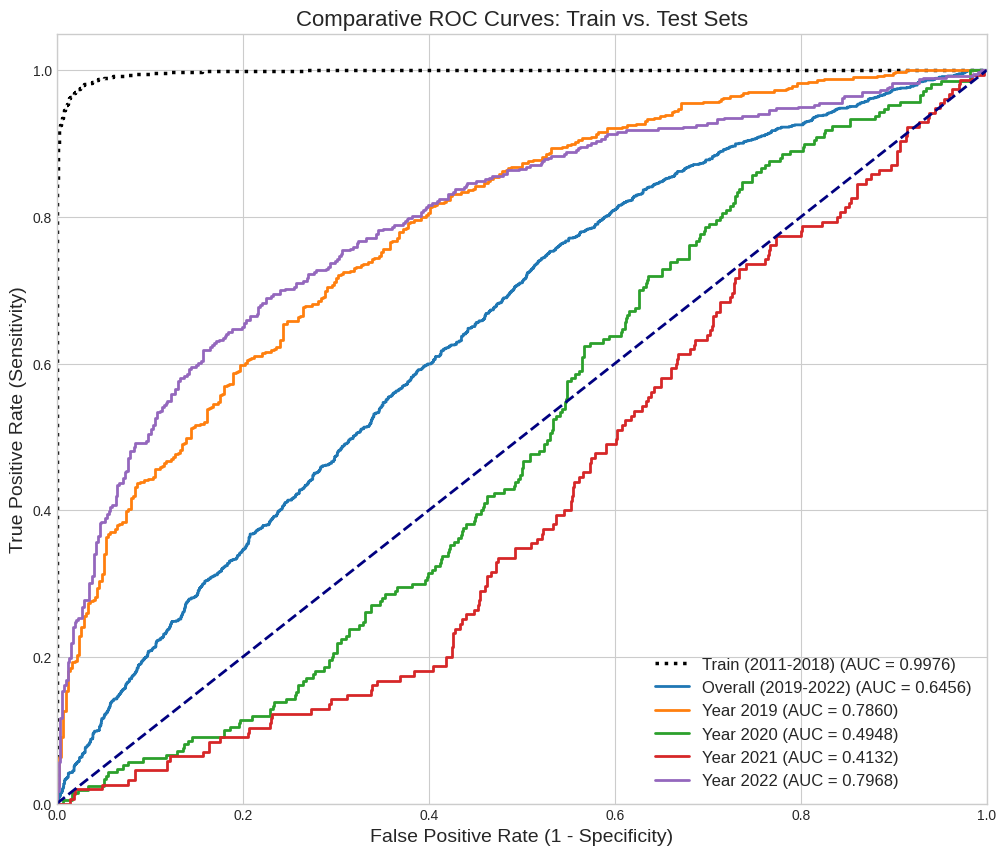

In [9]:
import pandas as pd
import joblib
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

print("\n" + "="*50)
print("PART 7: Preparing Multiple Test Sets")

# เราจะเก็บข้อมูลแต่ละชุดไว้ใน Dictionary เพื่อให้จัดการง่าย
test_sets = {}
X_train = X
y_train = y

try:
    # 1. Test set รวม (2019-2022)
    df_test_overall = df[(df['year'] >= 2019) & (df['year'] <= 2022)][columns_to_include]
    if not df_test_overall.empty:
        test_sets['Overall (2019-2022)'] = (df_test_overall[selected_features], df_test_overall['risk_binary'])
        print(f"Loaded 'Overall (2019-2022)' test set with {len(df_test_overall)} rows.")

    # 2. Test set แยกตามปี
    for year in [2019, 2020, 2021, 2022]:
        df_year = df[df['year'] == year][columns_to_include]
        if not df_year.empty:
            test_sets[f'Year {year}'] = (df_year[selected_features], df_year['risk_binary'])
            print(f"Loaded 'Year {year}' test set with {len(df_year)} rows.")
        else:
            print(f"Warning: No data found for year {year}.")

except NameError:
    print("Error: Could not create test sets. Please run the data preparation code (Part 2) first.")
    test_sets = {}

# ===================================================================
# โหลดโมเดลและคำนวณค่าสำหรับกราฟ ROC
# ===================================================================
if test_sets:
    print("\n" + "="*50)
    print("PART 8: Calculating ROC Curve Data for All Sets")

    # โหลดโมเดลที่บันทึกไว้
    model_filename = '/content/drive/MyDrive/Colab Notebooks/PKL2/XGBoost/XGBoost_model.pkl'
    loaded_model = joblib.load(model_filename)
    print(f"Model '{model_filename}' loaded successfully.")

    # Dictionary สำหรับเก็บข้อมูลที่จะพล็อต
    plot_data = {}

    # คำนวณ ROC สำหรับข้อมูล Train (เพื่อใช้เป็นเส้นเปรียบเทียบ)
    y_train_proba = loaded_model.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    auc_train = roc_auc_score(y_train, y_train_proba)
    plot_data['Train (2011-2018)'] = {'fpr': fpr_train, 'tpr': tpr_train, 'auc': auc_train}
    print(f"Calculated ROC for Train data (AUC = {auc_train:.4f})")

    # คำนวณ ROC สำหรับ Test Set แต่ละชุด
    for name, (X_test, y_test) in test_sets.items():
        y_pred_proba = loaded_model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plot_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}
        print(f"Calculated ROC for '{name}' (AUC = {auc:.4f})")

# ===================================================================
# สร้างและแสดงผลกราฟ ROC Curve เปรียบเทียบ
# ===================================================================
if 'plot_data' in locals() and plot_data:
    print("\n" + "="*50)
    print("PART 9: Plotting Comparative ROC Curves")

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 10))

    # วาดเส้น ROC ของข้อมูล Train เป็นเส้นหลัก
    train_data = plot_data['Train (2011-2018)']
    plt.plot(train_data['fpr'], train_data['tpr'],
             label=f"Train (2011-2018) (AUC = {train_data['auc']:.4f})",
             color='black', linewidth=2.5, linestyle=':')

    # วาดเส้น ROC ของ Test Set แต่ละชุด
    for name, data in plot_data.items():
        if "Train" not in name: # ไม่ต้องพล็อตข้อมูล Train ซ้ำ
            plt.plot(data['fpr'], data['tpr'],
                     label=f"{name} (AUC = {data['auc']:.4f})",
                     linewidth=2)

    # วาดเส้นอ้างอิง (การเดาสุ่ม)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # ตกแต่งกราฟ
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    plt.title('Comparative ROC Curves: Train vs. Test Sets', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()


--- 📊 Generating Feature Importance Plot and Table ---


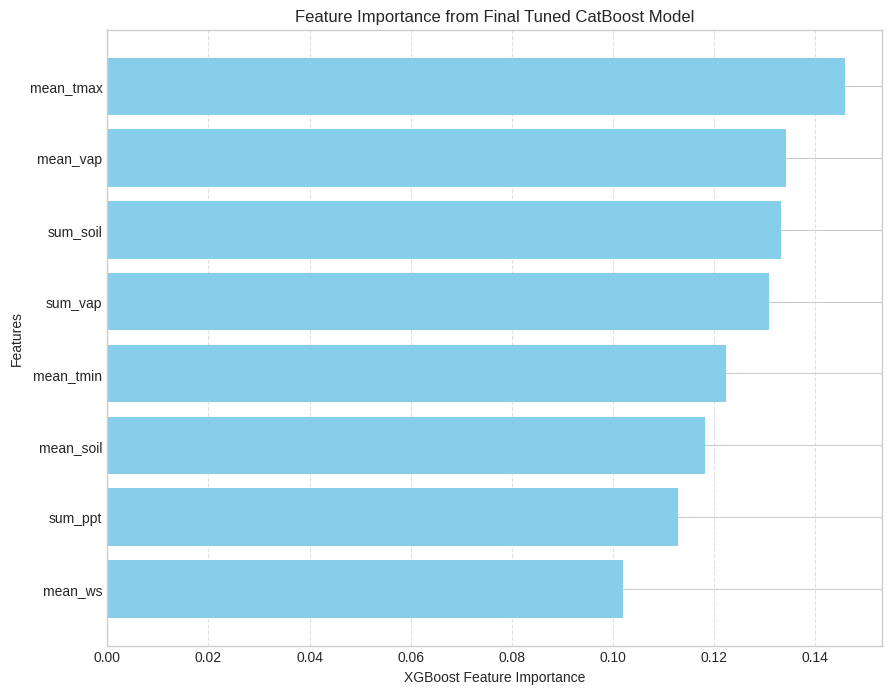


--- Feature Importance Table ---
     Feature  Importance
1  mean_tmax    0.146003
3   mean_vap    0.134248
6   sum_soil    0.133240
7    sum_vap    0.130865
2  mean_tmin    0.122397
0  mean_soil    0.118165
5    sum_ppt    0.112980
4    mean_ws    0.102101


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# ดึงค่า Feature Importance, สร้างกราฟ, และบันทึกไฟล์
print("\n--- 📊 Generating Feature Importance Plot and Table ---")

# ดึงค่าความสำคัญของฟีเจอร์ออกมาจากโมเดลสุดท้ายที่เทรนเสร็จแล้ว
feature_importances = final_model.feature_importances_

# ดึงรายชื่อของฟีเจอร์ (ชื่อคอลัมน์) จาก X_train
feature_names = X_train.columns

# สร้าง DataFrame เพื่อจัดเก็บข้อมูล (ชื่อฟีเจอร์คู่กับค่าความสำคัญ)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False) # เรียงลำดับจากมากไปน้อย

# พล็อตกราฟแบบแท่งแนวนอน (Horizontal Bar Chart)
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("XGBoost Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Final Tuned CatBoost Model")
plt.gca().invert_yaxis()  # กลับแกน Y เพื่อให้ฟีเจอร์ที่สำคัญที่สุดอยู่ด้านบน
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# แสดงผลตาราง Feature Importance
print("\n--- Feature Importance Table ---")
print(importance_df)